Fashion-MNIST分類

In [1]:
!pip install transformers

In [2]:
!pip install torchinfo

In [20]:
import os
import requests
import io

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from PIL import Image

from transformers import ViTImageProcessor, ViTModel

from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm

#Fashion-MNIST trainデータのダウンロード

In [4]:
#trainデータのみダウンロード
#http://mbd.riken.jp/VAE/Fashion_MNIST.html
URL = 'http://mbd.riken.jp/VAE/fashion_mnist_train.csv'
r = requests.get(URL)
df_train = pd.read_csv(io.BytesIO(r.content),sep=",")

In [5]:
df_train.head()

,ID,x0y0,x1y0,x2y0,x3y0,x4y0,x5y0,x6y0,x7y0,x8y0,...,x18y27,x19y27,x20y27,x21y27,x22y27,x23y27,x24y27,x25y27,x26y27,x27y27
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Fashion-MNISTの画像とLabelをnumpy arrayにして取り出す

In [6]:
#dataframeでは処理できないためnumpy arrayに
train_y = df_train.iloc[:,0].astype('int64').to_numpy()
train_X = df_train.iloc[:,1:].astype('float32').to_numpy()
print(f'y:{train_y.shape},X:{train_X.shape}')

y:(60000,),X:(60000, 784)


In [7]:
#フラット化されているので、28*28でreshape
train_X = train_X.reshape((60000,28,28))
train_X.shape #(datasize,width,height)

(60000, 28, 28)

#データセット

##クラスと関数の定義

In [8]:
#データセットの自作。確認のために使えるようtrialと、本番の学習用trainの2つのデータセットクラスを作成
class TrialDataset(torch.utils.data.Dataset):
    def __init__(self, X, labels, dataset_size, transform):
        self.f_mnist = X[:dataset_size]
        self.labels = labels[:dataset_size]
        self.transform = transform

    def __len__(self):
        return len(self.f_mnist)

    def __getitem__(self,idx):
      #Imageオブジェクトに直し、データ拡張を行う
      f_mnist = Image.fromarray(self.f_mnist[idx])
      f_mnist = self.transform(f_mnist)
      label = torch.tensor(self.labels[idx], dtype=torch.int64)
      return f_mnist, label

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, X, labels, transform):
        self.f_mnist = X
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.f_mnist)

    def __getitem__(self,idx):
      #Imageオブジェクトに直し、データ拡張を行う
      f_mnist = Image.fromarray(self.f_mnist[idx])
      f_mnist = self.transform(f_mnist)
      label = torch.tensor(self.labels[idx], dtype=torch.int64)
      return f_mnist, label

In [9]:
def load_train(dataset, batch_size):

  # データローダーの作成
  train_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, shuffle=True, num_workers=2)

  return train_loader

def load_test(dataset, batch_size):

  # データローダーの作成
  test_loader = torch.utils.data.DataLoader(
      dataset, batch_size=batch_size, shuffle=True, num_workers=2)

  return test_loader

In [10]:
#データセットの画像確認関数
def img_show(loader):

  labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
  }

#3*3枚確認できる
  fig = plt.figure(figsize=(9, 9))

  for i,(X,y) in enumerate(loader):
    if i>8:
      break
    image = np.transpose(torch.squeeze(X).numpy(), (1, 2, 0))
    image = np.clip(image, 0, 1)
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.set_title(f"{y.item()}: {labels_map[y.item()]}")
    ax.imshow(image)

##データセットの確認

In [74]:
#transformの定義。グレースケール化(3チャネルに拡張)、リサイズ、テンソル化、正規化の4つ
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [75]:
#100枚で試しにデータセット作成
trial_dataset = TrialDataset(train_X, train_y, 100, transform)

In [76]:
#バッチサイズを1にして画像を表示しやすくする
trial_loader = load_train(trial_dataset, 1)

In [77]:
#データのテンソルサイズ確認
for i,(x,_) in enumerate(trial_loader):
  print('-----[batch,channel,height,width-----]')
  print('x',x.size())
  if i>5:
    break

-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])
-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])
-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])
-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])
-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])
-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])
-----[batch,channel,height,width-----]
x torch.Size([1, 3, 224, 224])


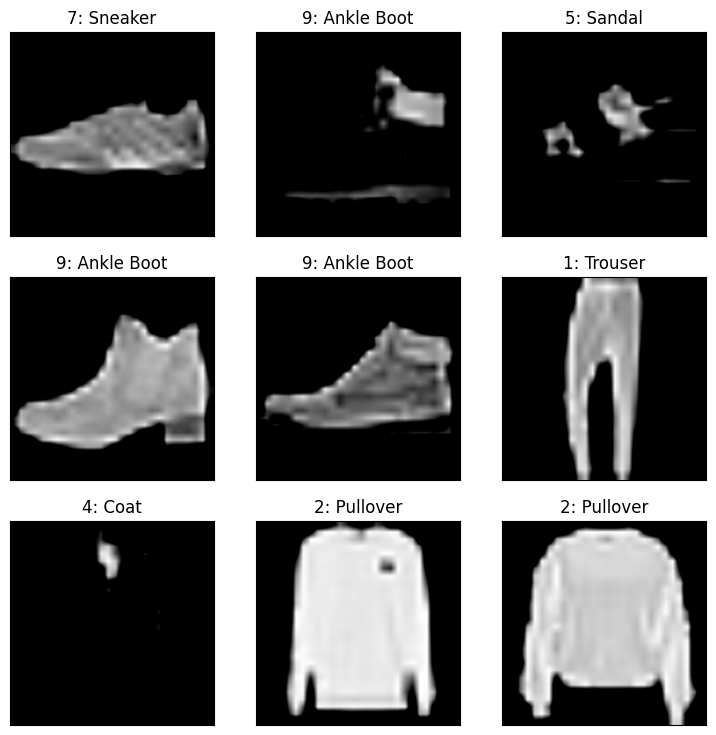

In [78]:
img_show(trial_loader)

#モデル作成

##事前学習済みViTモデル

In [11]:
#Huggingfaceより事前学習済みViTのダウンロード
#https://huggingface.co/google/vit-base-patch16-224-in21k
batch_size = 30
pretrained_vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
#アーキテクチャの確認
summary(model=pretrained_vit_model, input_size=(batch_size, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
ViTModel                                           [30, 768]                 --
├─ViTEmbeddings: 1-1                               [30, 197, 768]            152,064
│    └─ViTPatchEmbeddings: 2-1                     [30, 196, 768]            --
│    │    └─Conv2d: 3-1                            [30, 768, 14, 14]         590,592
│    └─Dropout: 2-2                                [30, 197, 768]            --
├─ViTEncoder: 1-2                                  [30, 197, 768]            --
│    └─ModuleList: 2-3                             --                        --
│    │    └─ViTLayer: 3-2                          [30, 197, 768]            7,087,872
│    │    └─ViTLayer: 3-3                          [30, 197, 768]            7,087,872
│    │    └─ViTLayer: 3-4                          [30, 197, 768]            7,087,872
│    │    └─ViTLayer: 3-5                          [30, 197, 768]            7,087,8

In [127]:
#イテレーターで1枚だけ取り出す
Iter = iter(trial_loader)
X, y = next(Iter)

In [128]:
#順伝播させて出力サイズを確認
result = pretrained_vit_model(X)
result['last_hidden_state'].size()

torch.Size([1, 197, 768])

In [ ]:
#CLSトークン
result['last_hidden_state'][:, 0, :]

##モデルの定義

In [12]:
#デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [67]:
#ViTモデルの定義
class ViTNet(nn.Module):
    def __init__(self, pretrained_vit_model, class_num):
        super(ViTNet, self).__init__()
        #事前学習済みViTに768*10の全結合層を追加
        self.vit = pretrained_vit_model
        self.fc = nn.Linear(768, class_num)

    #CLSトークン取得
    def _get_cls_vec(self, pretrained_vit_out):
        return pretrained_vit_out['last_hidden_state'][:, 0, :]

    def forward(self, X):
        X = self.vit(X)
        pretrained_vit_out = self._get_cls_vec(X)
        out = self.fc(pretrained_vit_out)
        return out

In [71]:
#学習関数
def trainer(train_dataloader, valid_dataloader, model, epoch, optimizer, loss_function, class_num):

  #ロスと正答率のログを格納する
  train_losses = []
  valid_losses = []
  train_accuracys = []
  valid_accuracys = []


  for epoch in range(epoch):

    train_loss = 0.0
    train_predict = []
    train_true = []
    #学習
    model.train()

    for x,y in tqdm(train_dataloader):

      #勾配初期化
      optimizer.zero_grad()

      x = x.to(device)
      y = y.to(device)
      result = model(x)
      loss = loss_function(result, y)
      #誤差逆伝播
      loss.backward()
      #パラメータ更新
      optimizer.step()

      train_predict += result.argmax(dim=1).cpu().detach().numpy().tolist()
      train_true += y.cpu().detach().numpy().tolist()
      train_loss += loss.item()

    # エポックごとの損失の合計とF1-scoreを計算する
    train_losses.append(train_loss)
    train_accuracy = accuracy_score(train_true, train_predict)
    train_accuracys.append(train_accuracy)

    valid_loss = 0.0
    valid_predict = []
    valid_true = []
    #検証
    model.eval()

    for x,y in valid_dataloader:

      #勾配初期化
      optimizer.zero_grad()

      x = x.to(device)
      y = y.to(device)
      result = model(x)
      loss = loss_function(result, y)

      valid_predict += result.argmax(dim=1).cpu().detach().numpy().tolist()
      valid_true += y.cpu().detach().numpy().tolist()
      valid_loss += loss.item()

    # エポックごとの損失の合計と正答率を計算する
    valid_losses.append(valid_loss)
    valid_accuracy = accuracy_score(valid_true, valid_predict)
    valid_accuracys.append(valid_accuracy)

    print('epoch', epoch,
          '\t train loss', round(train_loss, 4), '\t train accuracy', round(train_accuracy, 4),
          '\t val loss', round(valid_loss, 4), '\t val accuracy', round(valid_accuracy, 4)
          )
  return train_losses, valid_losses, train_accuracys, valid_accuracys

#ロスと正答率をプロットする関数
def plot_process(train_losses, valid_losses, train_accuracys, valid_accuracys):
  plt.figure(figsize=(15,5))

  plt.subplot(1,2,1)
  plt.plot(train_losses, '-o', label='train loss')
  plt.plot(valid_losses, '-^', label='val loss')
  plt.title('loss')
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(train_accuracys, '-o', label='train accuracy')
  plt.plot(valid_accuracys, '-^', label='val accuracy')
  plt.title('accuracy')
  plt.legend()
  plt.grid()

  plt.show()

#学習

##試し

In [47]:
batch_size = 10
dataset_size = 100
#データセットの作成
#まずtransformの設計
trial_transform = transforms.Compose([transforms.RandomRotation(degrees=(-180, 180)), #ランダムに回転
                                      transforms.Grayscale(num_output_channels=3), #今回使う事前学習モデルの入力チャネルに合わせる
                                      transforms.Resize((224, 224)), #今回使う事前学習モデルの入力サイズにアップスケール
                                      transforms.ToTensor(), #Tensor化
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) #今回使う事前学習モデルの正規化処理

#データセット作成。train X,y はnumpy array
trial_dataset = TrialDataset(train_X, train_y, dataset_size, trial_transform)
#訓練データと検証データに分割(8:2)
trial_train, trial_valid = torch.utils.data.random_split(trial_dataset, [len(trial_dataset)-20, 20])
#データローダーの作成
trial_train_loader = load_train(trial_train, batch_size)
trial_valid_loader = load_train(trial_valid, batch_size)

In [48]:
#ハイパーパラメータ
CLASS_NUM = 10
Ir = 1e-5
epoch = 10

#モデルの作成してdeviceへ
model = ViTNet(pretrained_vit_model, CLASS_NUM)
model.to(device)

#全パラメータの勾配計算をOFF
for param in model.parameters():
    param.requires_grad = False

#最終層の全結合層のパラメータのみ勾配計算をON
for param in model.fc.parameters():
    param.requires_grad = True

#損失関数
loss_function = nn.CrossEntropyLoss()
#オプティマイザー
optimizer = optim.Adam([{'params': model.fc.parameters(), 'lr': Ir}])

  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0 	 train loss 18.5556 	 train accuracy 0.05 	 val loss 4.6524 	 val accuracy 0.05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 1 	 train loss 18.5577 	 train accuracy 0.0875 	 val loss 4.6863 	 val accuracy 0.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2 	 train loss 18.4168 	 train accuracy 0.1375 	 val loss 4.6209 	 val accuracy 0.15


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3 	 train loss 18.4478 	 train accuracy 0.0625 	 val loss 4.6238 	 val accuracy 0.15


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4 	 train loss 18.4276 	 train accuracy 0.125 	 val loss 4.68 	 val accuracy 0.05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5 	 train loss 18.4655 	 train accuracy 0.0875 	 val loss 4.6254 	 val accuracy 0.05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 6 	 train loss 18.336 	 train accuracy 0.175 	 val loss 4.6681 	 val accuracy 0.05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 7 	 train loss 18.3973 	 train accuracy 0.0875 	 val loss 4.6833 	 val accuracy 0.05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 8 	 train loss 18.4733 	 train accuracy 0.05 	 val loss 4.657 	 val accuracy 0.05


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 9 	 train loss 18.3901 	 train accuracy 0.125 	 val loss 4.6331 	 val accuracy 0.05


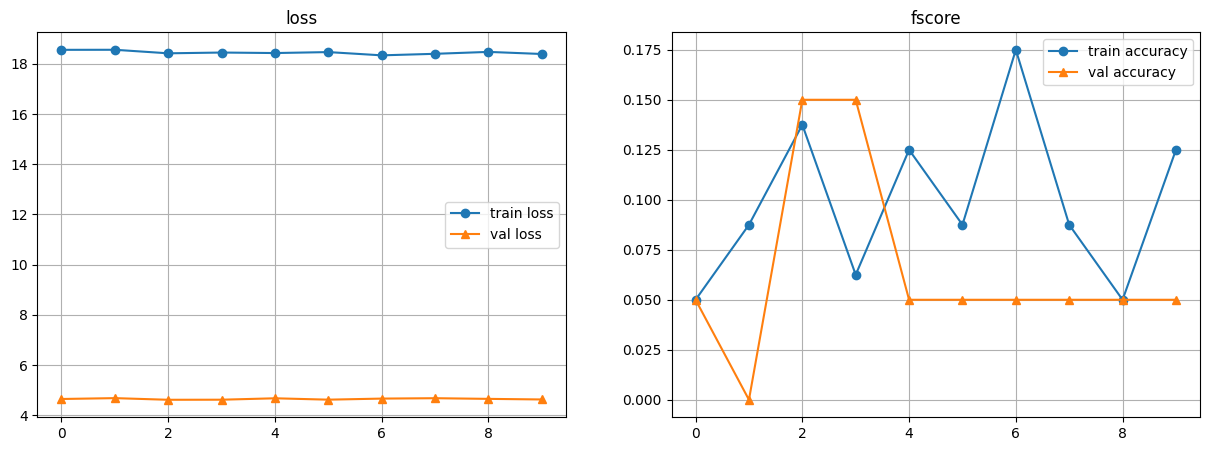

In [49]:
#学習
train_losses, valid_losses, train_accuracys, valid_accuracys = trainer(trial_train_loader, trial_valid_loader, model, epoch, optimizer, loss_function, CLASS_NUM)
plot_process(train_losses, valid_losses, train_accuracys, valid_accuracys)

##train

In [63]:
#10000のみ使用
train_X = train_X[:10000]
train_y = train_y[:10000]
train_X.shape

(10000, 28, 28)

In [68]:
batch_size = 200
#データセットの作成
#まずtransformの設計
train_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), #今回使う事前学習モデルの入力チャネルに合わせる
                                      transforms.Resize((224, 224)), #今回使う事前学習モデルの入力サイズにアップスケール
                                      transforms.ToTensor(), #Tensor化
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) #今回使う事前学習モデルの正規化処理

#データセット作成。train X,y はnumpy array
train_dataset = TrainDataset(train_X, train_y, train_transform)
#訓練データと検証データに分割(8:2)
train, valid = torch.utils.data.random_split(train_dataset, [len(train_dataset)-2000, 2000])
#データローダーの作成
train_loader = load_train(train, batch_size)
valid_loader = load_train(valid, batch_size)

In [72]:
#ハイパーパラメータ
CLASS_NUM = 10
Ir = 1e-4
epoch = 15

#モデルの作成してdeviceへ
model = ViTNet(pretrained_vit_model, CLASS_NUM)
model.to(device)

#全パラメータの勾配計算をOFF
for param in model.parameters():
    param.requires_grad = False

#最終層の全結合層のパラメータのみ勾配計算をON
for param in model.fc.parameters():
    param.requires_grad = True

#損失関数
loss_function = nn.CrossEntropyLoss()
#オプティマイザー
optimizer = optim.Adam([{'params': model.fc.parameters(), 'lr': Ir}])

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 	 train loss 89.4691 	 train accuracy 0.2586 	 val loss 21.5483 	 val accuracy 0.474


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 	 train loss 83.1457 	 train accuracy 0.6271 	 val loss 20.0376 	 val accuracy 0.7


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 2 	 train loss 77.3414 	 train accuracy 0.7359 	 val loss 18.6536 	 val accuracy 0.743


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 3 	 train loss 72.0363 	 train accuracy 0.7639 	 val loss 17.3893 	 val accuracy 0.764


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 4 	 train loss 67.207 	 train accuracy 0.7788 	 val loss 16.2416 	 val accuracy 0.7755


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 5 	 train loss 62.8276 	 train accuracy 0.7887 	 val loss 15.2031 	 val accuracy 0.782


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 6 	 train loss 58.8731 	 train accuracy 0.795 	 val loss 14.2635 	 val accuracy 0.7945


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 7 	 train loss 55.2986 	 train accuracy 0.8015 	 val loss 13.4218 	 val accuracy 0.7945


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 8 	 train loss 52.0884 	 train accuracy 0.8055 	 val loss 12.6647 	 val accuracy 0.8015


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 9 	 train loss 49.2048 	 train accuracy 0.8095 	 val loss 11.9885 	 val accuracy 0.8035


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 10 	 train loss 46.6249 	 train accuracy 0.8111 	 val loss 11.3813 	 val accuracy 0.8065


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 11 	 train loss 44.2925 	 train accuracy 0.8129 	 val loss 10.838 	 val accuracy 0.8085


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 12 	 train loss 42.2095 	 train accuracy 0.8156 	 val loss 10.3505 	 val accuracy 0.811


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 13 	 train loss 40.3323 	 train accuracy 0.8184 	 val loss 9.9099 	 val accuracy 0.8125


  0%|          | 0/40 [00:00<?, ?it/s]

epoch 14 	 train loss 38.6372 	 train accuracy 0.8211 	 val loss 9.5157 	 val accuracy 0.815


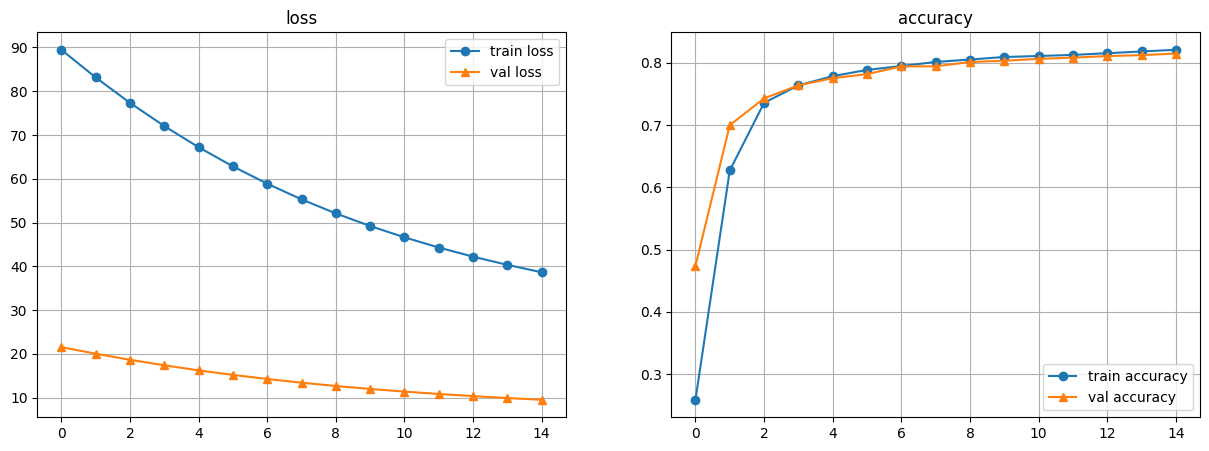

In [73]:
#学習
train_losses, valid_losses, train_accuracys, valid_accuracys = trainer(train_loader, valid_loader, model, epoch, optimizer, loss_function, CLASS_NUM)
plot_process(train_losses, valid_losses, train_accuracys, valid_accuracys)